# TP 4248 2021-2022 
## les membres du groupe
- fezeu Ghomsi Eugene Clotaire 17Q2864 
- Nono Mabou Wilfried Brondon 21S2817 brondonnono3@gmail.com
- NGBAYAFOU NGOUH Chéripha Cheriphalynette@gmail.com
- Junior Libii junior.libii@facsciences-uy1.cm

## binary naive bayes classification on sms dataset
on s'interesse ici a la presence ou l'abscende d'un mot dans corpus pour pour determiner si c'est un spam ou un ham

In [4]:
# -*- coding: utf-8 -*-

In [2]:
import os.path
from os import path
import getpass
filepath = ''
REPOPATH = 'fez2000/TP_4248.git'
FILENAME= 'spam.csv'
HOST='github.com'
if path.exists(f'./{FILENAME}'):
    filepath = f'./{FILENAME}'
elif path.exists(f'./datas/{FILENAME}'):
    filepath = f'./datas/{FILENAME}'
else:
    filepath = f'./datas/{FILENAME}'
    def load_from_git():
        def clone(): 
            GIT_PATH = f'https://{HOST}/{REPOPATH}' 
            !git clone {GIT_PATH} 'temp'
        def clone_by_token():
            GIT_TOKEN= getpass.getpass("votre token git") 
            GIT_PATH = f'https://{GIT_TOKEN}@{HOST}/{REPOPATH}' 
            !git clone {GIT_PATH} 'temp'
        def clone_by_username_and_password():
            GIT_USER_NAME= getpass.getpass("votre nom d'utilisateur git")
            GIT_PASSWORD= getpass.getpass("votre mot de pass git")
            GIT_PATH = f'https://{GIT_USER_NAME}:{GIT_PASSWORD}@{HOST}/{REPOPATH}'
            !git  clone  {GIT_PATH} 'temp' 
        if not path.exists(f'./temp/datas/{FILENAME}'):
            try:
                clone()
            except e:
                pass
        if not path.exists(f'./temp/datas/{FILENAME}'):
            try:
                clone_by_username_and_password()
            except e:
                pass
        if not path.exists(f'./temp/datas/{FILENAME}'):
            try:
                clone_by_token()
            except e:
                pass
        if not path.exists(f'./temp/datas/{FILENAME}'):     
            load_from_git()
        else:
            %cd './temp'

    load_from_git()

In [74]:
!pip install --user ipykernel
!python -m ipykernel install --user --name=venv
!pip install gensim
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install bs4
!pip install BeautifulSoup4
!pip install lxml
!pip install nltk
!python -m nltk.downloader all-nltk
!pip install tqdm
!pip install keras
!pip install textfixtures 

Installed kernelspec venv in /home/eugene/.local/share/jupyter/kernels/venv
/home/eugene/anaconda3/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all-nltk'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/eugene/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/eugene/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/eugene/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/eugene/nltk_data...

In [10]:
import pandas as pd
import re
import numpy as np
dataset = pd.read_csv(filepath, encoding="ISO-8859-1", usecols=['v1', 'v2'], dtype={'v1':str,'v2':str})
dataset = dataset.dropna(how="any")
dataset.rename(columns={'v2':'corpus', "v1": "target"}, inplace=True)
dataset.head(10)

,target,corpus
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
print(dataset.shape)

(5572, 2)


In [13]:
dataset['corpus'].apply(lambda x: len(x.split(' '))).sum()

86961

on a 86961  words, c'est un petit dataset.

/home/eugene/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


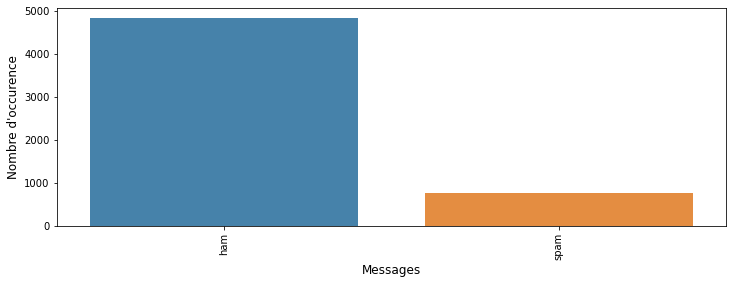

In [22]:
cnt_pro = dataset['target'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.9)
plt.ylabel('Nombre d\'occurence', fontsize=12)
plt.xlabel('Messages', fontsize=12)
plt.xticks(rotation=90)
plt.show();

### Text preprocessing

Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [11]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
dataset['corpus'] = dataset['corpus'].apply(cleanText)

In [23]:
dataset['corpus'][20]

'Is that seriously how you spell his name?'

Train/test split of 70/30.

In [40]:
train, test = train_test_split(dataset, test_size=0.3, random_state=42)
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [43]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [47]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['corpus']), tags=[r.target]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['corpus']), tags=[r.target]), axis=1)

This is what a training entry looks like - an example complaint narrative tagged by 'Credit reporting'.

In [55]:
train_tagged.values[30]

TaggedDocument(words=['as', 'valued', 'customer', 'am', 'pleased', 'to', 'advise', 'you', 'that', 'following', 'recent', 'review', 'of', 'your', 'mob', 'no', 'you', 'are', 'awarded', 'with', 'å£1500', 'bonus', 'prize', 'call', '09066364589'], tags=['spam'])

## Training the model

We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

### DBOW

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

We set the minimum word count to 2 in order to discard words with very few occurrences. 

In [49]:
import multiprocessing

cores = multiprocessing.cpu_count()

Build a vocabulary

In [50]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=1, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████████████████████████████| 3900/3900 [00:00<00:00, 1799140.52it/s]


In [51]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████| 3900/3900 [00:00<00:00, 759132.43it/s]


CPU times: user 12.8 s, sys: 1.96 s, total: 14.8 s
Wall time: 13 s


### Buliding the final vector feature for the classifier.

In [56]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [58]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [63]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/home/eugene/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.9515550239234449
Testing F1 score: 0.9508204584375209


### Distributed Memory with Averaging

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.
We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [68]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=5, negative=1, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|███████████████████████████████████| 3900/3900 [00:00<00:00, 999925.77it/s]


In [69]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████████████████████████████| 3900/3900 [00:00<00:00, 1815917.58it/s]


CPU times: user 26.2 s, sys: 4.96 s, total: 31.1 s
Wall time: 24.7 s


### Train Logistic Regression

In [70]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.9623205741626795
Testing F1 score: 0.9624292662574295


/home/eugene/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [75]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

ModuleNotFoundError: No module named 'testfixtures'

In [48]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [49]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [50]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6778572623828648
Testing F1 score: 0.664561533967402
